In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os
import os.path
import pickle
import sys
from functools import partial
from multiprocessing import Manager, Pool
import time
import datetime

import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, balanced_accuracy_score, recall_score, f1_score

from thesis.util import save_pickle as save, load_pickle as load

%matplotlib inline


In [2]:
dd = load("data/interim/data_dict")

dtc_res = joblib.load("data/results/dtc_gridsearch.joblib")
rfc_res = joblib.load("data/results/rfc_gridsearch.joblib")
svm_res = joblib.load("data/results/svm_gridsearch.joblib")

old_frame = load("data/out/data")
nvc_frame = load("data/out/data_nvc")

In [3]:
def build_variable_tag_set(df):
    d = dict()
    cols = df.columns
    for col in cols:
        tag = col[:2]
        if tag in d:
            d[tag].add(col)
        else:
            d[tag] = {col}

    return d

def add_value_labels(ax, spacing=-5, offset=0, precision=3, horizontal=False, fontsize="x-large"):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """ 
    
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2 if horizontal else rect.get_height()
        x_value = rect.get_width() if horizontal else rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
#         if y_value < 0:
#             # Invert space to place label below
#             space *= -1
#             # Vertically align label at top
#             va = 'top'

        # Use Y value as label and format number with one decimal place
        label = f"{x_value if horizontal else y_value : .{precision}f}"

        # Create annotation
        ax.annotate(
            s=label,                      # Use `label` as label
            xy=(x_value, y_value),         # Place label at end of the bar
            xytext=(space, offset) if horizontal else (offset, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha="right" if horizontal else 'center',                # Horizontally center label
            va="center" if horizontal else "top",  # Vertically align label differently for positive and negative values.
            rotation=0 if horizontal else 90,
            fontsize=fontsize,
            fontweight="roman",
            fontstretch='expanded'
        )
        
                   
def prep_train_test(x, y, svm=None, dtc=None, rfc=None):
    ohec = OneHotEncoder(categories="auto")
    x_ohec = ohec.fit_transform(x)
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)
    xtrain_ohec, xtest_ohec, ytrain_ohec, ytest_ohec = train_test_split(x_ohec,y,test_size=0.2)
    print(x.shape, x_ohec.shape)
    
    def fit(clf, name):
        x, y = (xtrain, ytrain) if name != "SVM" else (xtrain_ohec, ytrain_ohec)
        now = datetime.datetime.time(datetime.datetime.now())
        print(f"{now}: Training {name} ...", end=" ")
        t = time.time()
        fitted = clf.fit(x, y)
        print(f"Done in {time.time() - t:.3f}s")
        
        return fitted
    
    def score(clf, name):
        test_d = {"balanced accuracy" : balanced_accuracy_score, "precision" : precision_score, "recall" : recall_score, "f1" : f1_score}
        
        x, y = (xtest, ytest) if name != "SVM" else (xtest_ohec, ytest_ohec)
        t = time.time()
        now = datetime.datetime.time(datetime.datetime.now())
        print(f"{now}: Getting predictions from {name} ...", end=" ")
        predictions = clf.predict(x)
        print(f"Done in {time.time() - t:.3f}s")
        t = time.time()
        now = datetime.datetime.time(datetime.datetime.now())
        print(f"{now}: Scoring {name} ... ", end=" ")
        results = {test_name : test(y, predictions) for test_name, test in test_d.items()}
        print(f"Done in {time.time() - t:.3f}s")
        t = time.time()
        now = datetime.datetime.time(datetime.datetime.now())
        print(f"{now}: Scoring accuracy {name} ... ", end=" ")
        results["accuracy"] = clf.score(x, y)
        print(f"Done in {time.time() - t:.3f}s")
        
        return results
        
    def run(clf, name):
        out = {name:{}}
        clf = fit(clf, name)
        res = score(clf, name)
        out[name]["classifier"] = clf
        out[name]["results"] = res
        
        return out
        
    out = {}
    if dtc is not None:
        out.update(run(dtc, "DTC"))
    if svm is not None:
        out.update(run(svm, "SVM"))
    if rfc is not None:
        out.update(run(rfc, "RFC"))

    return out
          
                   
def show_importances(clf, train_frame, no=20, var_to_name=None):
    importances = clf.feature_importances_
    try:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    except AttributeError:
        pass
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    
    for i in range(no):
        var = train_frame.columns[indices[i]]
        if var.endswith(("_x", "_y")):
            var = var[:-2]
        if var_to_name:
            if var in var_to_name:
                name = var_to_name[var]
            else:
                name = "not_found: " + var
        else:
            name = var
        importance = importances[indices[i]]
        print(f"{i + 1:0>2}. feature {var:<15}: {name:<50} ({importance:.4f})")
    print()

### Class Balance

In [ ]:
vocTrain = pd.read_stata("data/raw/SC5_spVocTrain_D_11-0-0.dta", convert_categoricals=0)
vocTrain = vocTrain[vocTrain["subspell"]==0]
CATI = pd.read_stata("./data/raw/SC5_pTargetCATI_D_11-0-0.dta", convert_categoricals=False)

variables = [
    "ID_t",  # target id
    "wave",  # wave of episode
    "spell",  # spell id
    "ts15221_v1",  # angestrebter Ausbildungsabschluss
    "ts15219_v1",  # Ausbildungsabschluss: B.Sc, M.Sc, Ausbildung, etc.
    # "ts15265",  # Note des Abschluss
    # "tg24103",  # Episodenmodus
    "ts15201",  # Ausbildungstyp
    "ts15218",  # Erfolgreicher Abschluss
    "tg24159",  # Fachwechsel gegenüber Vorepisode; 1=same, 2=diff
    "tg24121",  # Hochschulwechsel gegenüber Vorepisode; 1=same, 2=diff
    # "ts1512c",  # Andauern der Episode
    # "ts1511m_g1",  # Prüfmodul: Startdatum (Monat, ediert)
    # "ts1511y_g1",  # Prüfmodul: Startdatum (Jahr, ediert)
    # "ts1512m_g1",  # Prüfmodul: Enddatum (Monat, ediert)
    # "ts1512y_g1",  # Prüfmodul: Enddatum (Jahr, ediert)
]

subset = vocTrain[
    (vocTrain["subspell"] == 0)
    & (vocTrain["disagint"] != 1)
][variables]

relevant_education = [
    10,  # Studium an einer Universität, auch pädagogische Hochschule, Kunst- und Musikhochschule
    # Studium an einer Fachhochschule, auch Hochschule für angewandte Wissenschaften oder University of Applied Sciences genannt (nicht Verwaltungsfachhochschule
    9,
    -28  # Wert aus Rekrutierung pTargetCATI ## might be relevant
]
relevant_courses_of_study = [
    13,  # BA ohne Lehramt
    #17, # Erstes Staatsexamen Lehramt
    8,  # BA
    12,  # BA Lehramt
    #-54, # Designbedingt fehlend
]
curr = subset[
    # filter for uni/fh only
    subset["ts15201"].isin(relevant_education) &
    subset["ts15221_v1"].isin(relevant_courses_of_study)  # filter bachelor only
]

# prepare subset of CATI for joining
other = CATI[
    # the question was only asked in wave 1, and this way ID_t becomes the unique identifier
    CATI["wave"] == 1
    & CATI["tg02001"].isin([1, 3])  # filter for 3=BA and 1=BA Lehramt only
][["tg02001", "ID_t"]]  # ID_t to join on, tg02001 holds the pursued degree

# join CATI subset into dataframe for more complete sample
curr = curr.join(other.set_index("ID_t"), on="ID_t")  # integrate tg02001 into df to fill in ts15201 -28
# filter out those rows that CATI added nothing too, meaning those without information on pursued degree even after joining
curr = curr[(curr["ts15201"] != -28) |
            ((curr["ts15201"] == -28) & (~curr["tg02001"].isnull()))]

cols = list(curr.columns)
purs_deg_idx = cols.index("ts15221_v1") + 1
cols = cols[:purs_deg_idx] + cols[-1:] + cols[purs_deg_idx:-1]
curr = curr[cols]

# filter out all students who have one spell with an unsuccesfull graduation
dropped_students = curr[(curr["ts15218"] == 2)]["ID_t"].unique()
dropped = curr[curr["ID_t"].isin(dropped_students)]

dropped1 = dropped[dropped["ts15218"]==2]
tmp = dropped[
    (dropped["ts15218"] == 2) &
    (dropped["ID_t"].isin(dropped["ID_t"].value_counts()
                          [dropped["ID_t"].value_counts() > 1].index))
]
# shift up all rows by one, then select those indices we filtered above
# this gives us the possibility to compare two subsequent rows using the same index
dropped2 = dropped.shift(-1).loc[tmp.index]
# We only want to compare rows for the same student, and then filter those who actually changed subject
# leaving out those who only switched institutions or had other reasons for ending their spell
# and also leaving out possible mismatches, where all recorded spells of interest were unsuccesfull,
# and thus the following row is already for the next student
dropped2 = dropped2[
    (dropped2["ID_t"] == tmp["ID_t"]) &
    (dropped2["tg24159"] == 2) &
    (dropped2["ts15218"] == 2)
]

valid_ids = dropped1[["ID_t", "spell"]].append(dropped2[["ID_t", "spell"]]).append(curr[curr["ts15218"] == 1][["ID_t", "spell"]])

valid_ids["tmp"] = valid_ids["ID_t"].astype(int).astype(str) + "_"  + valid_ids["spell"].astype(int).astype(str)
valid_ids = valid_ids.drop_duplicates("tmp").drop(columns="tmp")

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
curr[curr["ts15218"].isin([1,2])]["ts15218"].value_counts().plot(kind="barh", title="Class Balance", rot=0, color=["#1f77b4", "#ff7f0e"])
ax.set_yticklabels(["Successful", "Unsuccessful"], fontsize=12)
ax.set_title("Class Balance", fontsize=13)
plt.tight_layout()
add_value_labels(ax, precision=0, fontsize=13, horizontal=1)
# plt.savefig("../tex/images/classbalance_hrz.png")
plt.show()

### Start - End Month plot

In [ ]:
df = pd.merge(valid_ids, vocTrain, on=["ID_t", "spell"], how="inner")

cols = ["ID_t", "spell", "ts15218"] + [c for c in df.columns if c.endswith(("m_g1", "y_g1"))]
df = df[cols]
df[df.isna()] = -1

df["start"] = df['ts1511y_g1'].astype(int).astype(str) + "-" + df['ts1511m_g1'].astype(int).astype(str) + "-01"
df["end"] = df['ts1512y_g1'].astype(int).astype(str) + "-" + df['ts1512m_g1'].astype(int).astype(str) + "-01"

df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["end"] = pd.to_datetime(df["end"], errors="coerce")

df = df[~(
        (df["ts1511y_g1"] < 2000) |
        (df["ts1512y_g1"] < 2000) |
        (df["ts1511y_g1"].isna()) |
        (df["ts1512y_g1"].isna())
    )
]

datevars = {
    "spGap": {"start_m": "ts2911m_g1", "start_y": "ts2911y_g1", "end_m": "ts2912m_g1", "end_y": "ts2912y_g1"},
    "spMilitary": {"start_m": "ts2111m_g1", "start_y": "ts2111y_g1", "end_m": "ts2112m_g1", "end_y": "ts2112y_g1"},
    "spUnemp": {"start_m": "ts2511m_g1", "start_y": "ts2511y_g1", "end_m": "ts2512m_g1", "end_y": "ts2512y_g1"},
    "spIntenrship": {"start_m": "tg3607m_g1", "start_y": "tg3607y_g1", "end_m": "tg3608m_g1", "end_y": "tg3608y_g1"},
    "spPartner": {"start_m": "tg2811m", "start_y": "tg2811y", "end_m": "tg2804m", "end_y": "tg2804y"},
    "spEmp": {"start_m": "ts2311m_g1", "start_y": "ts2311y_g1", "end_m": "ts2312m_g1", "end_y": "ts2312y_g1"},
    "spInternship": {"start_m": "tg3607m_g1", "start_y": "tg3607y_g1", "end_m": "tg3608m_g1", "end_y": "tg3608m_g1"},
    "pTargetCATI": {"start_m": "start_m", "start_y": "start_y", "end_m": None, "end_y": None},
    "pTargetCAWI": {"start_m": "start_m", "start_y": "start_y", "end_m": None, "end_y": None}
}

month_dict = {}
for dfk in dd:
    if not dfk in datevars or not dfk.startswith("sp"):
        continue
    start_month = datevars[dfk]["start_m"]
    end_month = datevars[dfk]["end_m"]
    months = dd[dfk][[start_month, end_month]]
    months = months[months.isin(range(1,13))]
    month_values = pd.DataFrame({"start_month": months[start_month].value_counts(), "end_month": months[end_month].value_counts()*-1})
    month_dict[dfk] = month_values

# Plot
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

bar_width = 0.9/len(month_dict)
alpha=.9
fig, ax = plt.subplots(figsize=(20,16))

ax.plot([0,14],[0,0], c="#000000", lw=.6, alpha=1)
ax.add_patch(patches.Rectangle((0, -.5), 14, .5, color="gray", alpha=.05))

ax.add_patch(patches.Rectangle((4-0.05-bar_width/2, -.5), 1, 1, color="cyan", alpha=.15))
ax.add_patch(patches.Rectangle((10-0.05-bar_width/2, -.5), 1, 1, color="cyan", alpha=.15))

for i, k in enumerate(month_dict.keys()):
    starts = month_dict[k]["start_month"]
    starts = softmax((starts - starts.mean()) / starts.std())
#     starts = (starts - starts.min()) / (starts.max() - starts.min())
    ends = month_dict[k]["end_month"]
    ends = -1*softmax((ends - ends.mean()) / ends.std())
#     ends = -1*(ends - ends.min()) / (ends.max() - ends.min())
    
    start_c = plt.get_cmap("Accent")(i*bar_width)
    end_c = tuple(np.append((np.array(start_c)[:-1] * .85), 1))
    ax.bar(starts.index + i * bar_width, starts.values, bar_width, alpha=alpha, label=k, color=start_c)
    ax.bar(ends.index + i * bar_width, ends.values, bar_width, alpha=alpha, color=end_c)
    


ax.annotate(
    s="Relative Episode Starts",
    xy=(1, .45),
    fontsize=18,
    fontweight="roman",
    fontstretch='expanded'
)
ax.annotate(
    s="Relative Episode Ends",
    xy=(1, -.45),
    fontsize=18,
    fontweight="roman",
    fontstretch='expanded'
)

for i in range(2,13):
    ax.axvline(x=i-.05-bar_width/2, ymin=.4, ymax=.6, color="black", linestyle="--", lw=.6)

ax.set_title(f"Start and End Month Spread", fontsize=20)
ax.set_xlabel("Month", fontsize=18)
ax.set_ylabel("Relative Amount\n<- Ending | Starting ->", fontsize=18)
ax.set_xticks(month_dict["spMilitary"].index + 2 * bar_width)
ax.set_xticks(np.arange(1,13) + bar_width * len(month_dict)/2 )
ax.set_xticklabels(range(1,13), fontsize=16)
ax.set_xlim(1-2*bar_width,12+bar_width*(len(month_dict)+1))
ax.set_yticks(np.arange(-0.4, 0.5, 0.2))
ax.set_ylim(-0.5,.5)
ax.set_yticklabels(np.append(np.arange(0.4,.1,-.2), np.arange(0,0.5,0.2)))
ax.legend(fontsize=18)
    
    
plt.tight_layout()
# plt.savefig("../tex/images/spell_start_end_months.png")
plt.show()

In [ ]:
id_success = pd.merge(valid_ids, vocTrain[["ID_t", "spell", "ts15218"]], on=["ID_t", "spell"], how="inner")

hm_d = {}
try:
    for dfk in dd:
        if not dfk in datevars or not dfk.startswith("sp"):
            continue
        heatmap_p = np.zeros((12,12))
        heatmap_n = np.zeros((12,12))
        start_month = datevars[dfk]["start_m"]
        end_month = datevars[dfk]["end_m"]
        months = dd[dfk][["ID_t", start_month, end_month]]
        months = pd.merge(months, id_success, on="ID_t", how="outer")
        for i, row in months.iterrows():
            startm = row[start_month]
            endm = row[end_month]
            if np.isnan(startm) or np.isnan(endm) or (not ((0 < startm < 13) and (0 < endm < 13))):
                continue
            startm = int(startm)
            endm = int(endm)
            if row["ts15218"] == 1:
                heatmap_p[startm-1][endm-1] += 1
            else:
                heatmap_n[startm-1][endm-1] += 1
#             heatmap[startm-1][endm-1] += row["ts15218"]
    #     month_values = pd.DataFrame({"start_month": months[start_month].value_counts(), "end_month": months[end_month].value_counts()*-1})
        hm_d[dfk] = [heatmap_p, heatmap_n]
except (IndexError, ValueError) as  e:
    print(startm, endm, row["ts15218"])
    print(type(startm), type(endm), type(row["ts15218"]))
    print(heatmap)
    raise e
    
fig, ax = plt.subplots(6, 2, figsize=(18, 45))
# ax = ax.flatten()
for i, (k, hm) in enumerate(hm_d.items()):
    axp = ax[i][0]
    axn = ax[i][1]
    sns.heatmap(hm[0], ax=axp)
    sns.heatmap(hm[1], ax=axn)
    axp.set_title(f"{k} Success")
    axp.set_xlabel("Start Month")
    axp.set_ylabel("End Month")
    axn.set_xlabel("Start Month")
    axn.set_ylabel("End Month")
    axn.set_title(f"{k} Unsuccessful")
    
plt.show()

### Best Configuration Plots

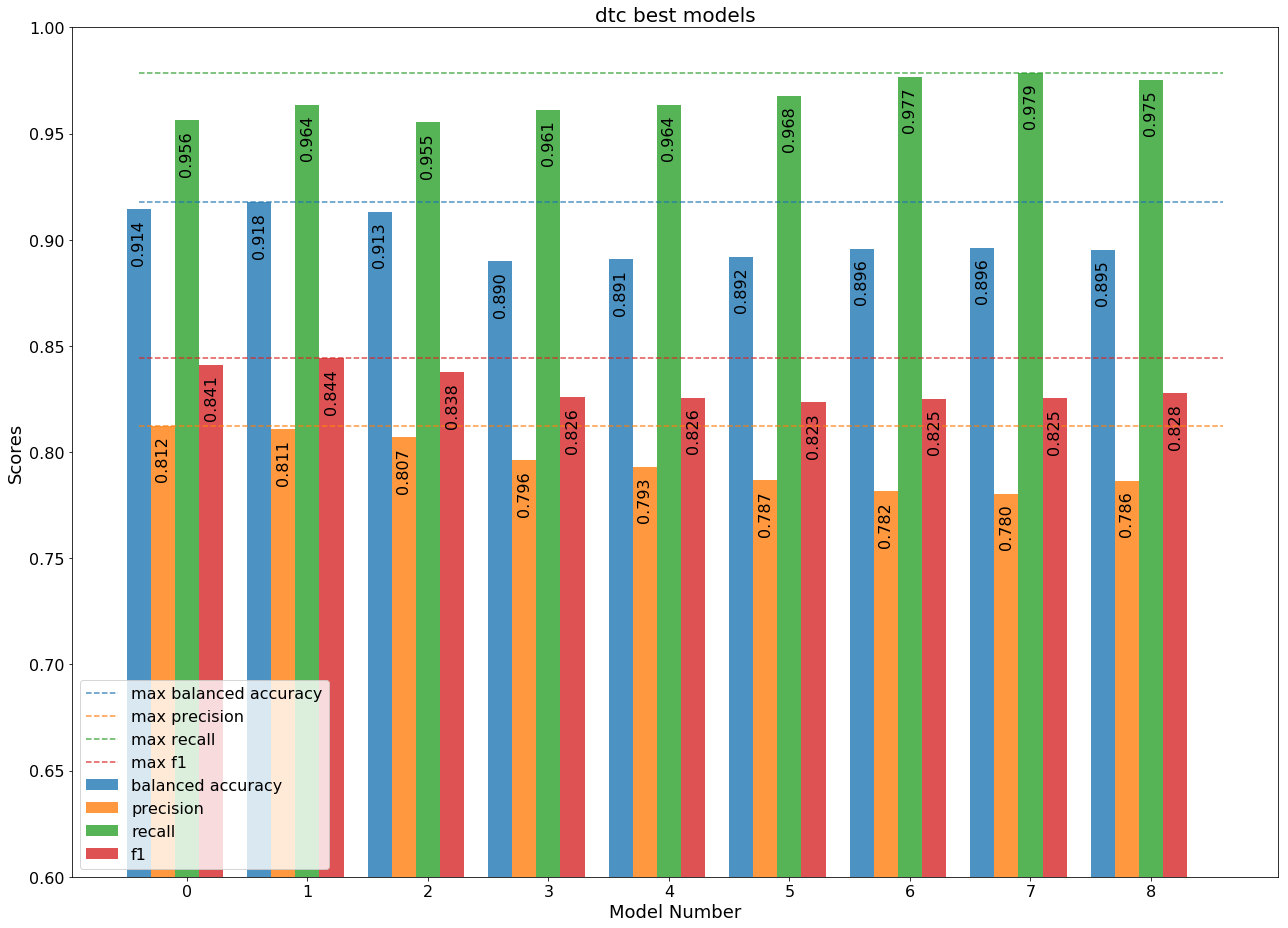

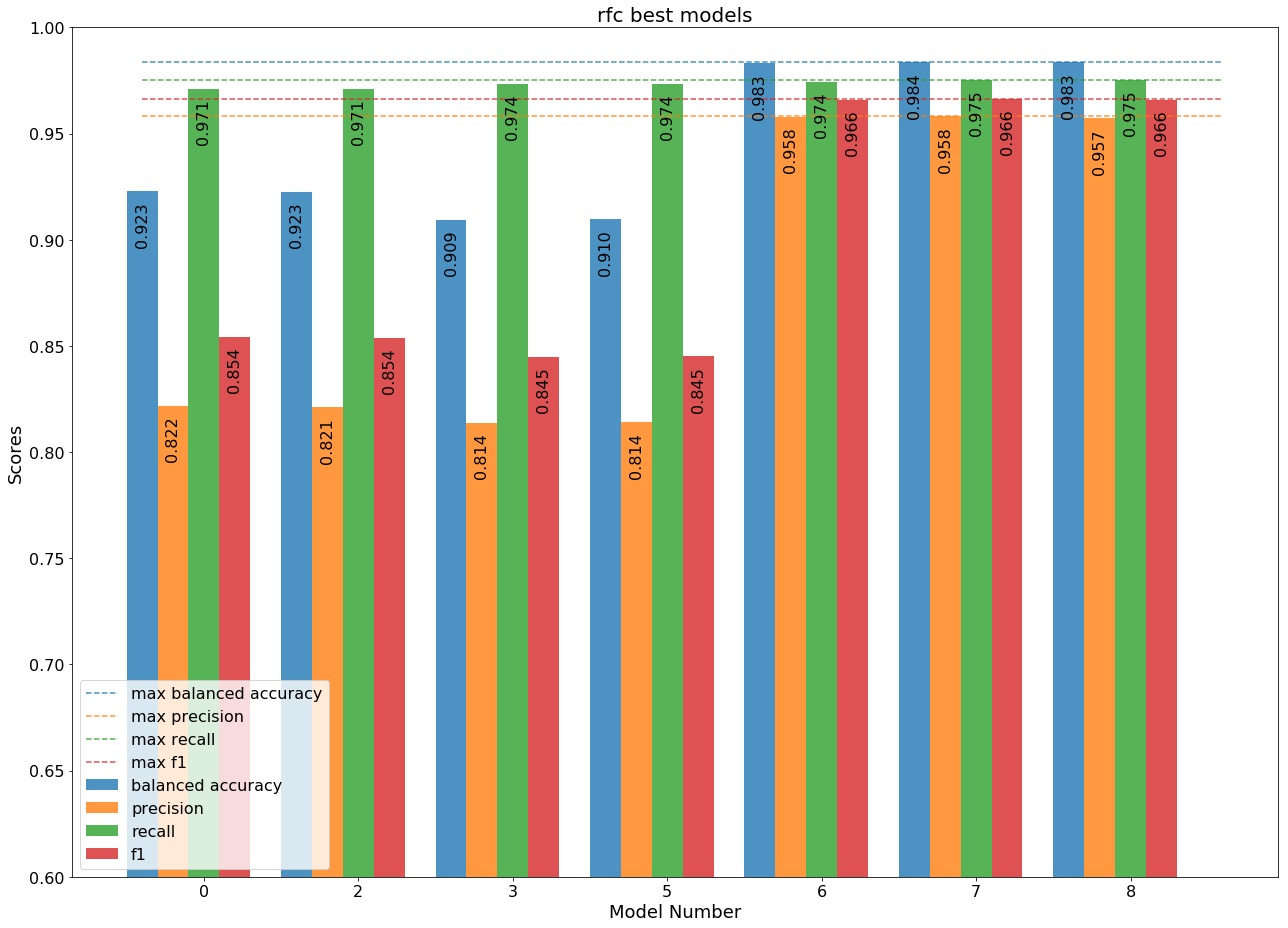

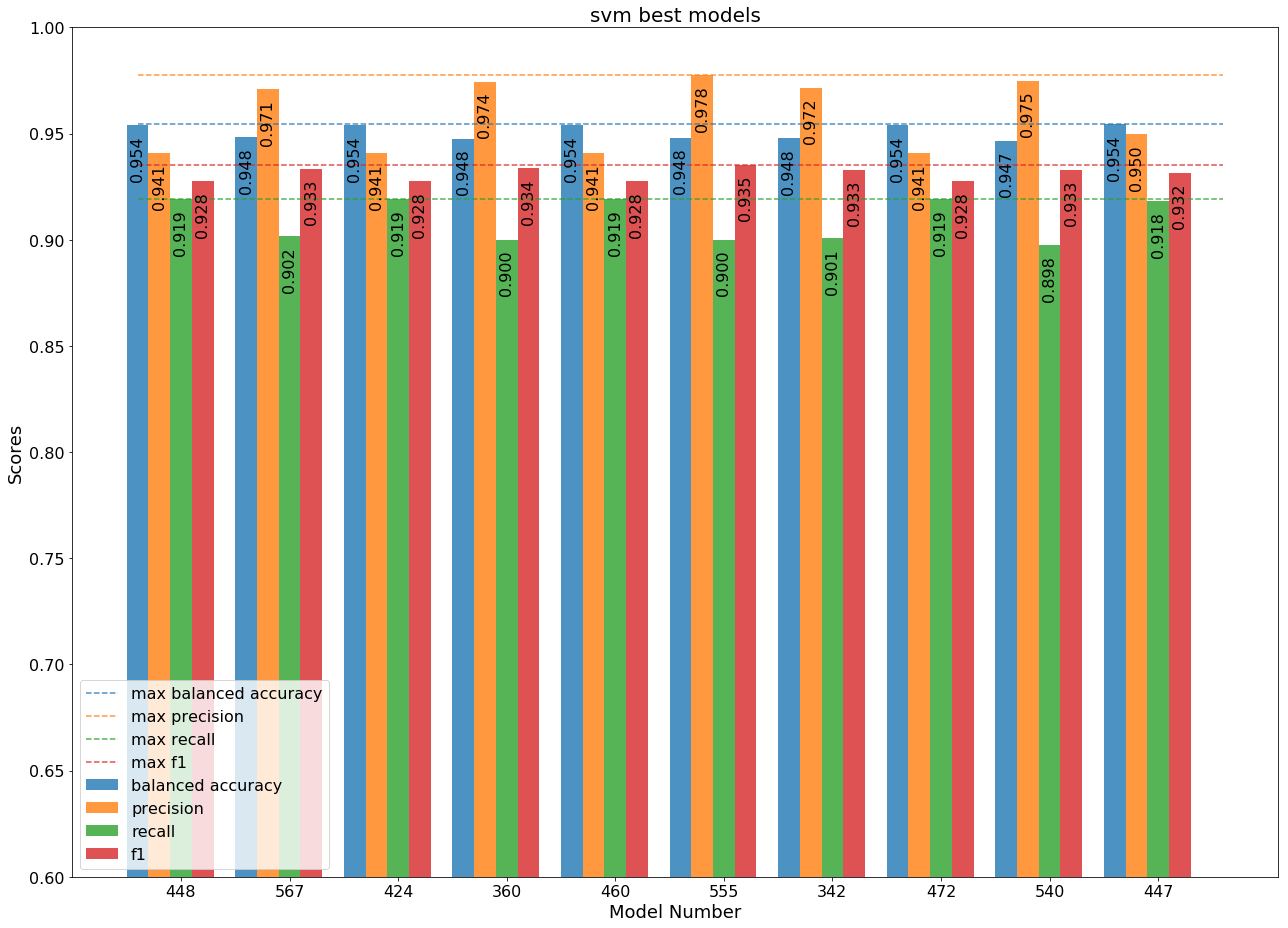

In [17]:
test_colour_map = {"accuracy":"#1f77b4", "precision":"#ff7f0e", "recall":"#2ca02c", "f1":"#d62728", "score":"#9467bd"}


splits = [f"split{x}" for x in range(5)]
tests = ["accuracy", "precision", "recall", "f1"]
testnames = [[f"{split}_test_{test}" for split in splits] for test in tests]


# fig, ax = plt.subplots(3, 1, figsize=(18,39))
fig1, ax1  = plt.subplots(figsize=(18,13))
fig2, ax2 = plt.subplots(figsize=(18,13))
fig3, ax3 = plt.subplots(figsize=(18,13))
ax = [ax1, ax2, ax3]
figs = [fig1, fig2, fig3]
names = ["results_dtc", "results_rfc", "results_svm"]
bar_width = 0.2
opacity = 0.8

res_d = {"dtc":dtc_res, "rfc":rfc_res, "svm":svm_res}

for plot_n, clf in enumerate(res_d):
    res = res_d[clf]
    test_avg = {}
    for testset in testnames:
        arr = []
        for test in testset:
            arr.append(res.cv_results_[test])
        test_avg[testset[0].split("_")[-1]] = np.stack(arr).mean(axis=0)
    s = set()
    for k in test_avg:
        s = s.union(set(test_avg[k].argsort()[-5:]))
    for k in test_avg:
        for s_ in list(s):
            if test_avg[k][s_] < 0.7:
                s.remove(s_)
    s = list(s)
    for k in test_avg:
        test_avg[k] = test_avg[k][s]
    
    
    index = np.arange(len(s))
    for i, k in enumerate(test_avg.keys()):
        ax[plot_n].bar(index + i * bar_width, test_avg[k], bar_width, alpha=opacity, label="balanced " + k if "acc" in k else k, color=test_colour_map[k])
        ax[plot_n].plot(np.arange(len(s)+1), [max(test_avg[k]) for _ in range(len(index)+1)], "--", label=f'max {"balanced " + k if "acc" in k else k}', alpha=opacity, color=test_colour_map[k])
    
#     for idx in index:
#         print(s[idx], f"{np.mean([v[idx] for _, v in test_avg.items()]):.3f}")
#     print()
                        
    ax[plot_n].set_title(f"{clf} best models", fontsize=20)
    ax[plot_n].set_xlabel("Model Number", fontsize=18)
    ax[plot_n].set_ylabel("Scores", fontsize=18)
    ax[plot_n].set_xticks(index + 2 * bar_width)
    ax[plot_n].set_xticklabels([f"{x}" for x in s], fontsize=16)
    ax[plot_n].set_ylim((0.6,1))
    ax[plot_n].set_yticks(np.arange(.6,1.01,.05))
    ax[plot_n].set_yticklabels([f"{s:.2f}" for s in np.arange(.6,1.01,.05)], fontsize=16)
    ax[plot_n].legend(loc=3, fontsize=16)
    
    add_value_labels(ax[plot_n], spacing=-10, fontsize=16)

[f.tight_layout() for f in figs]
[f.savefig(f"../tex/images/{names[plot_n]}.png") for f in figs]
plt.show()

# plt.tight_layout()
# plt.savefig(fig=fig1, "fig1.png")
# plt.savefig(fig=fig2, "fig2.png")
# plt.savefig(fig=fig3, "fig3.png")
# plt.show()

### Retrain and Eval

In [4]:
dtc_best_model = 1
rfc_best_model = 7
svm_best_model = 447

In [5]:
dtc_base = DTC(**dtc_res.cv_results_["params"][dtc_best_model])
rfc_base = RFC(n_estimators=8000, max_features=None, bootstrap=True, n_jobs=-1, **rfc_res.cv_results_["params"][rfc_best_model])
svm_base = SVC(cache_size=1000, **svm_res.cv_results_["params"][svm_best_model])

y = old_frame["ts15218"]
x = old_frame.drop(columns=["ts15218"])
int_x = x.drop(columns=[c for c in x.columns if c.split("_")[0].endswith("y")])
new_x = int_x.drop(columns=["ts15265", "ts15219_v1"])
newer_x = new_x.drop(columns=["tg50007"])
nvc_x = nvc_frame.drop(columns=["ts15218"])

In [9]:
print("Old:")
old_results = prep_train_test(x, y, svm_base, dtc_base, rfc_base)

Old:
(9551, 848) (9551, 13912)
13:02:54.980822: Training DTC ... Done in 1.901s
13:02:56.883260: Getting predictions from DTC ... Done in 0.014s
13:02:56.897263: Scoring DTC ...  Done in 0.007s
13:02:56.904272: Scoring accuracy DTC ...  Done in 0.015s
13:02:56.919258: Training SVM ... Done in 147.719s
13:05:24.639467: Getting predictions from SVM ... Done in 34.429s
13:05:59.068205: Scoring SVM ...  Done in 0.006s
13:05:59.075420: Scoring accuracy SVM ...  Done in 34.780s
13:06:33.855013: Training RFC ... Done in 782.997s
13:19:36.852651: Getting predictions from RFC ... Done in 13.456s
13:19:50.312826: Scoring RFC ...  Done in 0.014s
13:19:50.326839: Scoring accuracy RFC ...  Done in 13.542s


In [ ]:
print("Intermediate:")
int_results = prep_train_test(int_x, y, svm_base, dtc_base, rfc_base)

In [10]:
print("New:")
new_results = prep_train_test(new_x, y, svm_base, dtc_base, rfc_base)

New:
(9551, 873) (9551, 14138)
20:52:57.933589: Training DTC ... Done in 1.960s
20:52:59.894032: Getting predictions from DTC ... Done in 0.015s
20:52:59.910046: Scoring DTC ...  Done in 0.006s
20:52:59.916037: Scoring accuracy DTC ...  Done in 0.016s
20:52:59.932041: Training SVM ... Done in 141.674s
20:55:21.605997: Getting predictions from SVM ... Done in 33.296s
20:55:54.902509: Scoring SVM ...  Done in 0.006s
20:55:54.908510: Scoring accuracy SVM ...  Done in 49.820s
20:56:44.729255: Training RFC ... Done in 2244.305s
21:34:09.034722: Getting predictions from RFC ... Done in 2.651s
21:34:11.685320: Scoring RFC ...  Done in 0.007s
21:34:11.692321: Scoring accuracy RFC ...  Done in 2.445s


In [30]:
print("Even Newer:")
newer_results = prep_train_test(newer_x, y, svm_base, dtc_base, rfc_base)

Even Newer:
(9551, 872) (9551, 14133)
22:27:26.204836: Training DTC ... Done in 2.077s
22:27:28.299732: Getting predictions from DTC ... Done in 0.034s
22:27:28.333750: Scoring DTC ...  Done in 0.048s
22:27:28.390549: Scoring accuracy DTC ...  Done in 0.047s
22:27:28.437584: Training SVM ... Done in 172.309s
22:30:20.758537: Getting predictions from SVM ... Done in 42.133s
22:31:02.891495: Scoring SVM ...  Done in 0.160s
22:31:03.072764: Scoring accuracy SVM ...  Done in 42.297s
22:31:45.384487: Training RFC ... Done in 2188.167s
23:08:13.562631: Getting predictions from RFC ... Done in 147.420s
23:10:40.991967: Scoring RFC ...  Done in 0.147s
23:10:41.139001: Scoring accuracy RFC ...  Done in 190.188s


In [ ]:
print("No VocTrain:")
nvc_results = prep_train_test(nvc_x, y, svm_base, dtc_base, rfc_base)

In [31]:
save(old_results, "old_results")
save(int_results, "int_results")
save(new_results, "new_results")
save(newer_results, "newer_results")
save(nvc_results, "nvc_results")

### Plot results and anaylze features

In [6]:
old_results = load("data/eval/old_results")
int_results = load("data/eval/int_results")
new_results = load("data/eval/new_results")
newer_results = load("data/eval/newer_results")
nvc_results = load("data/eval/no_voctrain_results")

In [7]:
dd = load("data/interim/data_dict")
var_names = {}
for dfk in dd:
    fp = f"data/raw/SC5_{dfk}_D_11-0-0.dta"
    itr = pd.read_stata(fp, iterator=True)
    var_names.update(itr.variable_labels())

No-VocTrain
tg51300_v1 	 Fachwechsel seit letzter Befragung
t300460 	 Subjektive Erfolgswahrscheinlichkeit  Studienabschluss Master
tg52011 	 bislang erreichte ECTS-Punkte
tg52030 	 Entsprechung Studienpensum mit Studienordnung?
t31240b 	 Studienwechsel

Original
ts1512y_g1 	 Prüfmodul: Enddatum (Jahr, ediert)
ts15265 	 Note Ausbildungsabschluss
ts15219_v1 	 Ausbildungsabschluss
ts1511y_g1 	 Prüfmodul: Startdatum (Jahr, ediert)
tg24103 	 Episodenmodus

Correction-1
ts15219_v1 	 Ausbildungsabschluss
ts15265 	 Note Ausbildungsabschluss
tg52000 	 Leistungsbewertung nach ECTS?
tg24103 	 Episodenmodus
t731101 	 Familienform bis zum 15. Lebensjahr

Correction-2
ts15223 	 Ausbildung mind. 1 Monat im Ausland absolviert
employment_average_net_income 	 employment_average_net_income
tg52041 	 erfolgreich im Studium verglichen mit anderen
tg52000 	 Leistungsbewertung nach ECTS?
t66408a 	 Motivation: spätere Berufschancen



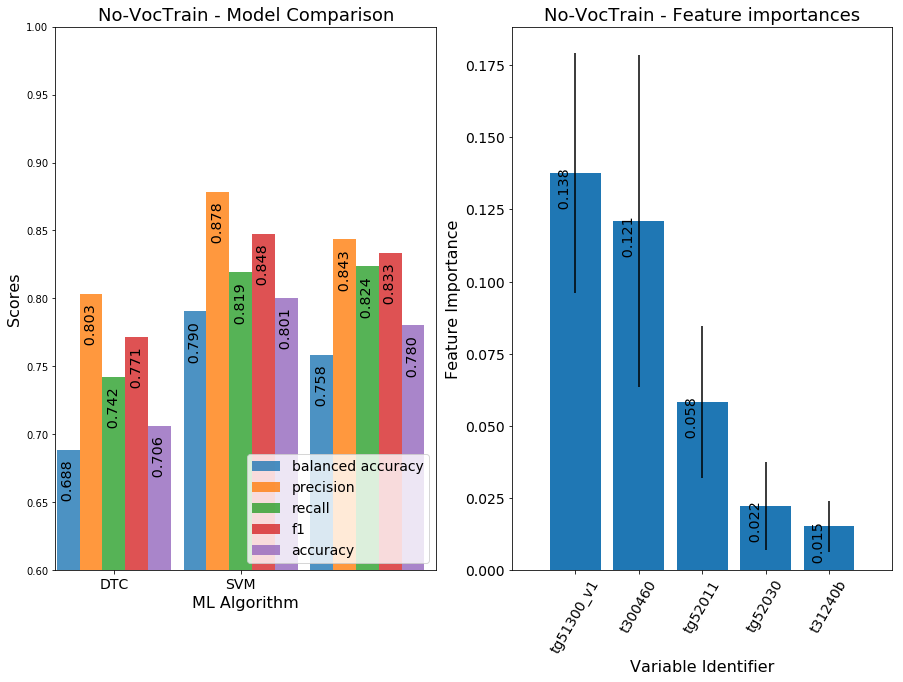

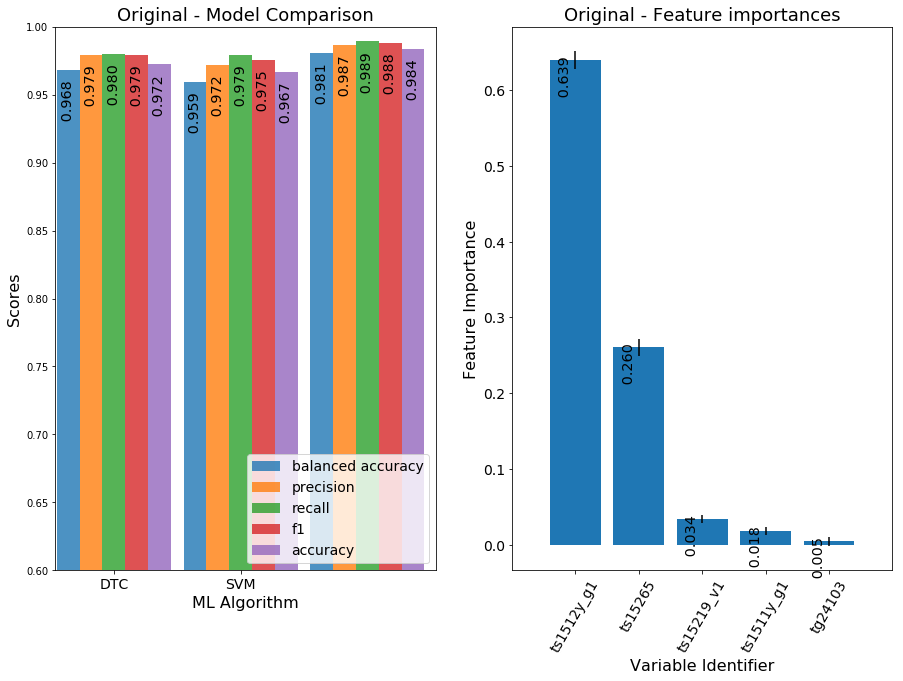

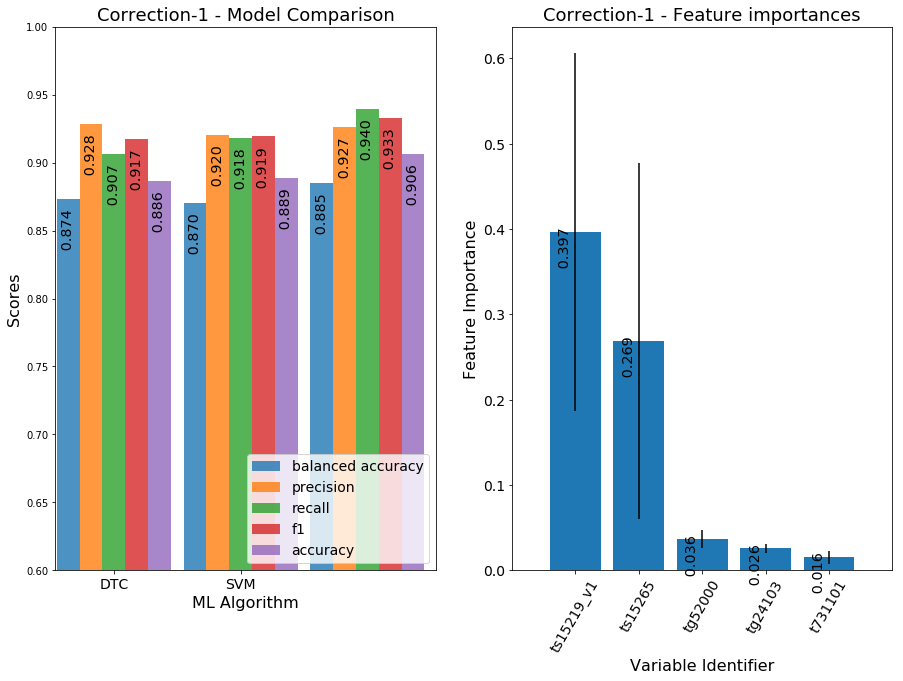

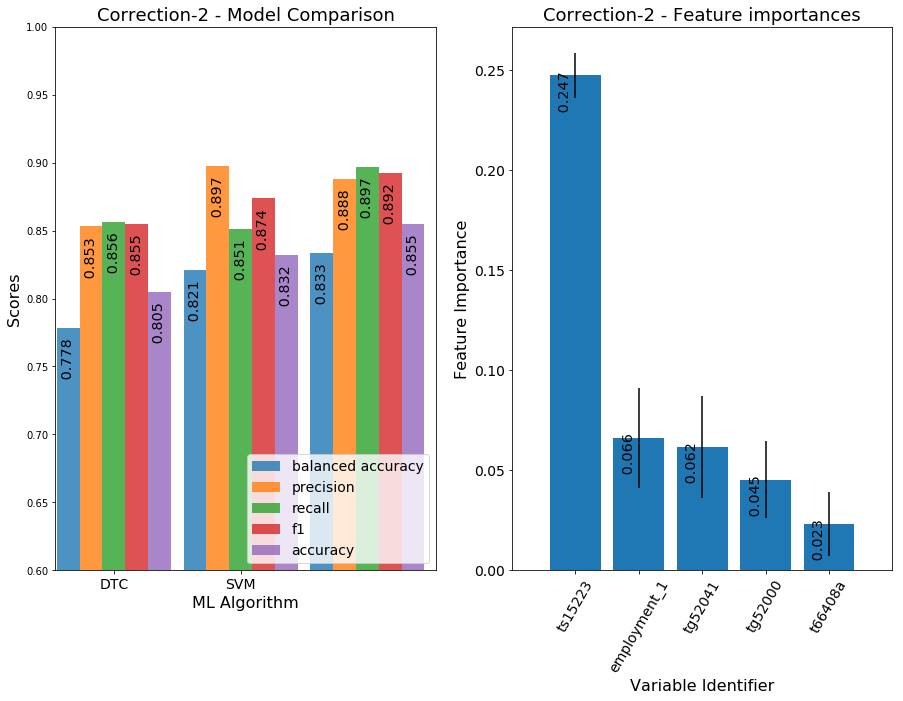

In [24]:
model_dict = {"No-VocTrain": [nvc_results, nvc_x], "Original":[old_results, x], "Correction-1":[int_results, int_x], "Correction-2":[newer_results, newer_x]}
figs, axs = tuple(zip(*[plt.subplots(1, 2, figsize=(15,10)) for _ in range(len(model_dict))]))

bar_width = 0.18
bar_spacing = 0.0
opacity = 0.8
test_colour_map = {"balanced accuracy":"#1f77b4", "precision":"#ff7f0e", "recall":"#2ca02c", "f1":"#d62728", "accuracy":"#9467bd"}


for plot_n, (name, info) in enumerate(model_dict.items()):
    fig = figs[plot_n]
    ax = axs[plot_n][0]
    res = info[0]
    for idx, key in enumerate(res.keys()):
        model_name = key
        scores = res[key]["results"]
        for i, (score_name, score) in enumerate(scores.items()):
            c = test_colour_map[score_name] if score_name in test_colour_map else None
            ax.bar(idx + i * (bar_width+bar_spacing), score, bar_width, alpha=opacity, label=score_name if idx == 0 else "", color=c)
        
    ax.set_title(f"{name} - Model Comparison", fontsize=18)
    ax.set_xlabel("ML Algorithm", fontsize=16)
    ax.set_ylabel("Scores", fontsize=16)
    ax.set_xticks(np.arange(idx) + len(scores)/2 * bar_width - bar_width/2)
    ax.set_xticklabels([f"{x}" for x in res], fontsize=14)
    ax.set_ylim((0.6,1))
    ax.set_xlim(-(bar_width/2+0.01),len(res)-1+bar_width*5)
    ax.legend(loc=4, fontsize=14)
    
    add_value_labels(ax, spacing=-10, horizontal=0)
    
    
    ax = axs[plot_n][1]
    train_frame = info[1]
    clf = res["RFC"]["classifier"]
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    no_feat = 5
    ax.bar(range(no_feat), importances[indices[:no_feat]], color="#1f77b4", yerr=std[indices[:no_feat]], align="center")
    ax.set_title(f"{name} - Feature importances", fontsize=18)
    ax.set_xlabel("Variable Identifier", fontsize=16)
    ax.set_ylabel("Feature Importance", fontsize=16)
    ax.set_xticks(range(no_feat))
    xticks = train_frame.columns[indices[:no_feat]]
    xticks = [tick[:-2] if tick.endswith(("_x","_y")) else tick for tick in xticks]
    xticks = [tick.split("_")[0]+"_1" if len(tick) > 12 else tick for i, tick in enumerate(xticks)]
    ax.set_xticklabels(xticks, fontsize=14, rotation=60)
    ax.set_xlim([-1, no_feat])
    ax.tick_params(axis="y", labelsize=14)
    
    add_value_labels(ax, spacing=5, offset=-10, horizontal=0)
#     ax.set_yticks(np.arange(0,0.7, 0.1))
#     ax.set_yticklabels([f"{s:.1f}" for s in np.arange(0,0.7, 0.1)], fontsize=14)
    
    fig.savefig(f"../tex/images/eval_{name}.png")
#     fig.tight_layout()
    
    print(name)
    [print(var,"\t", var_names[var]) if var in var_names else print(var,"\t", var) for var in [tick[:-2] if tick.endswith(("_x","_y")) else tick for tick in train_frame.columns[indices[:no_feat]]]]
    print()
plt.show()

# Neural Network

In [18]:
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold as KFold

from thesis.util import save_pickle as save, load_pickle as load

In [6]:
frame = load("data/out/data")
y = frame["ts15218"]
x = frame.drop(columns=["ts15218"])

In [7]:
def fully_connected(x, target_size, activation_function=None, normed=False, bias_init=0.0):
    fan_in = int(x.shape[-1])

    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev=2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)

    var_init = tf.constant_initializer(bias_init)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)

    activation = tf.matmul(x, weights) + biases

    return activation_function(activation) if callable(activation_function) else activation

def make_dataset(X_data, y_data, n_splits):    
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data, y_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train.todense(), X_test.todense(), y_train, y_test

    return tf.data.Dataset.from_generator(gen, (tf.float64, tf.float64, tf.float64, tf.float64))

In [8]:
ohec = OneHotEncoder(categories="auto")
x_ohec = ohec.fit_transform(x).todense()
dataset = make_dataset(x_ohec, y, n_splits=5)
iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
data_init_op = iterator.make_initializer(dataset)
next_fold = iterator.get_next()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
batch_sizes = [60, 75, 120, 300, 500]

hidden_layers = [
        (256, 1024, 2048, 512, 16),
        (2048, 512, 128, 16, 8),
        (16, 256, 512, 128, 8), 
        (512, 64, 8),
        (100)
]

optimizers = tf.train.AdamOptimizer
beta1s = [0.85, 0.9, 0.95],
beta2s = [0.9, 0.95, 0.99, 0.999]

lr = [0.001, 0.005, 0.01, 0.0005]
decay_coef = [0.5, 0.8, .95]

activations = [tf.nn.relu, tf.nn.tanh]
epoch_counts = [5, 15, 25, 50, 100, 200, 500]

In [10]:
class Model:
    
    def __init__(
        self,
        x, y, n_splits,
        batch_size,
        layer_config,
        optimizer_params,
        epochs,
        activation,
        init_lr,
        decay_exp=None,
        path="./data/results/ffn/"
    ):
        global model_count
        model_count += 1
        self.model_no = model_count
        self.dir = path + f"model_{model_count:0>3}/"
        self.summary_dir = path + f"summaries/model_{model_count:0>3}/"
        if not os.path.isdir(self.dir):
            os.makedirs(self.dir)
        if not os.path.isdir(self.summary_dir):
            os.makedirs(self.summary_dir)
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.epochs = epochs
        self.n_splits = n_splits
        self.create(
            x, y, n_splits,
            batch_size,
            layer_config,
            optimizer_params,
            epochs,
            activation,
            init_lr,
            decay_exp=None
         )

        
    def create(
        self,
        x, y, n_splits,
        batch_size,
        layer_config,
        optimizer_params,
        epochs,
        activation,
        init_lr,
        decay_exp=None
        ):
        tf.reset_default_graph()

        self.g_step = tf.get_variable('global_step', trainable=False, initializer=0)

        self.input_data = tf.placeholder(tf.float32, [batch_size, x.shape[1]])
        self.input_labels = tf.placeholder(tf.float32, [batch_size])
        self.input_labels = self.input_labels - tf.constant(1, tf.float32)

        data = self.input_data
        for i, hidden_n in enumerate(layer_config):
            with tf.variable_scope(f"layer_{i}"):
                data = fully_connected(data, hidden_n, activation_function=activation)

        self.logits = tf.reshape(fully_connected(data, 1, activation_function=None), [self.batch_size])
        self.out = tf.round(tf.nn.sigmoid(self.logits))
        self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.input_labels, logits=self.logits)
        self.loss = tf.reduce_mean(self.cross_entropy)

        if decay_exp is None:
            self.learning_rate = init_lr
        else:
            self.learning_rate = tf.train.exponential_decay(
                learning_rate=init_lr,
                global_step=self.g_step,
                decay_steps=x.shape[0]//batch_size*epochs,
                decay_rate=decay_exp
            )

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, **optimizer_params)
        self.step = self.optimizer.minimize(self.loss, global_step=self.g_step)

        self.accuracy, self.accuracy_op =  tf.metrics.accuracy(self.input_labels, self.out)
        self.precision, self.precision_op = tf.metrics.precision(self.input_labels, self.out)
        self.recall, self.recall_op = tf.metrics.recall(self.input_labels, self.out)
        self.f1 = (2 * self.precision * self.recall) / (self.precision + self.recall)
        
        tf.summary.scalar("accuracy", self.accuracy_op)
        tf.summary.scalar("precision", self.precision_op)
        tf.summary.scalar("recall", self.recall_op)
        tf.summary.scalar("f1", self.f1)
        
        self.summaries = tf.summary.merge_all()
    
    
    def run(self):
        train_writer = tf.summary.FileWriter(self.summary_dir + "/train", flush_secs=2)
        valid_writer = tf.summary.FileWriter(self.summary_dir + "/validation", flush_secs=2)
        saver = tf.train.Saver()
        
        batch_size = self.batch_size
        
        with tf.Session() as sess:
            sess.run(tf.local_variables_initializer())
            sess.run(tf.global_variables_initializer())
            for e in range(self.epochs):
                print(f"Starting epoch {e+1}...", end="\n", flush=True)
                for train_index, test_index in KFold(self.n_splits).split(self.x, self.y):
                    x_train, x_test = self.x[train_index], self.x[test_index]
                    y_train, y_test = self.y[train_index], self.y[test_index]
                    
                    for i in range(x_train.shape[0] // batch_size):
                        batch = x_train[i*batch_size:(i+1)*batch_size]
                        labels = y_train[i*batch_size:(i+1)*batch_size]
                        _, summaries = sess.run([self.step, self.summaries],
                                feed_dict={self.input_data: batch, self.input_labels: labels})
                        
                        train_writer.add_summary(summaries, self.g_step)
                        
                    loss, summ = sess.run([self.loss, self.summaries], feed_dict={self.input_data : x_test, self.input_labels: y_test})
                    valid.writer.add_summary(summ, global_step)
                    print(f"{'':.<10}", flush=True)
                print(f"Latest loss: {loss}", flush=True)
                    
            save_path = saver.save(sess, os.join(self.dir, "model"), global_step=self.g_step)

In [11]:
model_count = 0

In [12]:
model = Model(
    x_ohec, y, 5,
    batch_size=60,
    layer_config=[1024, 512, 64, 8],
    optimizer_params={"beta1":0.9, "beta2":0.99},
    epochs=5,
    activation=tf.nn.relu,
    init_lr=0.005,
    decay_exp=None,
    path="./data/results/ffn/"
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [13]:
model.run()

Starting epoch 1...


InternalError: Blas GEMM launch failed : a.shape=(60, 22459), b.shape=(22459, 1024), m=60, n=1024, k=22459
	 [[node layer_0/MatMul (defined at <ipython-input-7-d5284c56ad31>:13) ]]
	 [[node accuracy/update_op (defined at <ipython-input-10-b820dae52405>:83) ]]

Caused by op 'layer_0/MatMul', defined at:
  File "C:\Users\nipsh\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\nipsh\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\nipsh\Anaconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\nipsh\Anaconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\nipsh\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-de8957e0685b>", line 10, in <module>
    path="./data/results/ffn/"
  File "<ipython-input-10-b820dae52405>", line 37, in __init__
    decay_exp=None
  File "<ipython-input-10-b820dae52405>", line 63, in create
    data = fully_connected(data, hidden_n, activation_function=activation)
  File "<ipython-input-7-d5284c56ad31>", line 13, in fully_connected
    activation = tf.matmul(x, weights) + biases
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2455, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5333, in mat_mul
    name=name)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\nipsh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(60, 22459), b.shape=(22459, 1024), m=60, n=1024, k=22459
	 [[node layer_0/MatMul (defined at <ipython-input-7-d5284c56ad31>:13) ]]
	 [[node accuracy/update_op (defined at <ipython-input-10-b820dae52405>:83) ]]


In [ ]:
for batch_size in batch_sizes:
    for layer_config in hidden_layers:
        for beta1 in beta1s:
            for beta2 in beta2s:
                optimizer_params = {"beta1":beta1, "beta2":beta2}
                for epochs in epoch_counts:
                    for activation in activations:
                        for init_lr in lr:
                            for decay_exp in decay_coef:
                                create_and_run(x_ohec, y, 3, batch_size, layer_config, optimizer_params, epochs, activation, init_lr, decay_exp)

                            create_and_run(x_ohec, y, 3, batch_size, layer_config, optimizer_params, epochs, activation, init_lr)